# <center> CLAP Analysis </center>

#### <center> Analyzing our generated music with the CLAP model

In [1]:
from datasets import Dataset, Audio
import librosa
import torchaudio
import torch.nn.functional as F
import torch
from matplotlib import pyplot as plt
import numpy as np

from transformers import ClapModel, ClapProcessor

class CLAPAnalysis:
    def __init__(self, model_checkpoint="laion/clap-htsat-unfused"):
        self.model_checkpoint = model_checkpoint
        self.model = ClapModel.from_pretrained(model_checkpoint)
        self.processor = ClapProcessor.from_pretrained(model_checkpoint)
        self.sample_rate = self.processor.feature_extractor.sampling_rate

    def resample(self, waveform, sample_rate):
        """Resample the audio waveform so that it matches the model's sample rate.
        
        Args:
            waveform (array): The audio waveform to resample.
            sample_rate (int): The sample rate of the waveform.

        Returns:
            (array): The resampled waveform.
        """
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        return waveform

    def split(self, sample_array, batch_duration=5):
        """Split the audio into batches of the desired duration to track the embeddings over time.
        
        Args:
            sample_array (array): The audio waveform to split.
            batch_duration (int): The duration of each batch in seconds.

        Returns:
            (list(array)): A list of arrays, each representing a batch of the audio.
        """
        waveform = sample_array.squeeze()
        batch_size = int(batch_duration * self.sample_rate)
        pad_size = batch_size - (len(waveform) % batch_size)
        if pad_size < batch_size:   # Add silence to fill out last section
            waveform = torch.cat((waveform, torch.zeros(pad_size)))
        return [arr.numpy() for arr in waveform.reshape(-1, batch_size)]

    def preprocess_audio(self, audio, batch_duration=5):
        """Do audio proprocessing, inclusing resampling and splitting into batches.
        
        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            batch_duration (int): The duration of each batch in seconds.
        
        Returns:
            (list(array)): A list of arrays, each representing a batch of the audio.
        """
        if isinstance(audio, str):
            sample_array, sample_rate = torchaudio.load(audio)
        elif isinstance(audio, tuple):
            sample_array, sample_rate = audio
        elif isinstance(audio, dict):
            sample_array, sample_rate = audio['array'], audio['rate']
        else:
            raise ValueError("Audio input is not recognized. Must be a file path, a tuple of waveform "
                             "and sample rate, or a dictionary with 'array' and 'rate' keys.")
        return self.split(self.resample(sample_array, sample_rate), batch_duration)

    def embed_audio(self, audio, batch_duration=5):
        """Embeds the audio into the CLAP feature space.

        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            batch_duration (int): The duration of each batch in seconds.

        Returns:
            (array): The audio embeddings.
        """
        samples = self.preprocess_audio(audio, batch_duration=batch_duration)
        inputs = self.processor(audios=samples, return_tensors="pt", sampling_rate=self.sample_rate)
        with torch.no_grad():
            outputs = self.model.get_audio_features(**inputs)
        return outputs

    def embed_text(self, text):
        """Embeds the text into the CLAP feature space.

        Args:
            text (list(str)): A list of texts to process.

        Returns:
            (array): The text embeddings.
        """
        inputs = self.processor(text=text, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = self.model.get_text_features(**inputs)
        return outputs

    def analyze(self, audio, classes, batch_duration=5):
        """Analyzes the audio and text classes to determine the similarity between the two.

        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            classes (list(str)): A list of texts to compare to the audio batches.
            batch_duration (int): The duration of each batch in seconds.

        Returns:
            (array): The similarity scores between each batch of audio and the text classes.
        """
        audio_embeddings = F.normalize(self.embed_audio(audio, batch_duration), p=2, dim=1)
        text_embeddings = F.normalize(self.embed_text(classes), p=2, dim=1)
        return torch.matmul(audio_embeddings, text_embeddings.T)

    def plot(self, audio, classes, batch_duration=5):
        """Plots the similarity scores between the audio and text classes over time."""
        scores = self.analyze(audio, classes, batch_duration)
        num_sections = scores.shape[0]
        plt.plot(np.arange(1, num_sections+1)*batch_duration, scores.numpy())
        plt.legend(classes)
        plt.xlabel("Seconds")
        plt.ylabel("Score")
        plt.ylim(-.5, .5)
        plt.title("Song Emotion Progression")
        plt.show()


In [2]:
model_checkpoint = "laion/clap-htsat-unfused"
analysis_model = CLAPAnalysis(model_checkpoint=model_checkpoint)

/home/cayjobla/PAGES/.venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
audio_file = "data/balrag.wav"
audio_embeddings = analysis_model.embed_audio(audio_file, batch_duration=5) # Audio is split into 5 second sections
text_embeddings = analysis_model.embed_text(["happy", "sad", "angry"])
print(audio_embeddings.shape, text_embeddings.shape, sep="\n")

torch.Size([18, 512])
torch.Size([3, 512])


In [5]:
classes = ["joy", "sadness", "fear", "anger", "romantic", "peaceful", "dark"]
analysis_model.analyze(audio_file, classes, batch_duration=5)

tensor([[-0.0201,  0.2691,  0.3806,  0.1745,  0.1631,  0.1871,  0.3546],
        [-0.0270,  0.2272,  0.3767,  0.1703,  0.0884,  0.1616,  0.3570],
        [-0.0453,  0.2499,  0.3702,  0.1870,  0.0752,  0.1815,  0.3655],
        [-0.0393,  0.1982,  0.3762,  0.1791,  0.0951,  0.1214,  0.3611],
        [-0.0740,  0.2090,  0.3476,  0.1586,  0.0578,  0.1421,  0.3505],
        [ 0.0230,  0.2765,  0.3949,  0.1886,  0.1580,  0.1686,  0.3737],
        [ 0.0492,  0.3796,  0.4177,  0.1924,  0.1770,  0.2576,  0.4339],
        [-0.0166,  0.2049,  0.3824,  0.2094,  0.0718,  0.1978,  0.3571],
        [ 0.0353,  0.2958,  0.3588,  0.1426,  0.1762,  0.2769,  0.3923],
        [-0.0297,  0.2027,  0.3885,  0.1818,  0.0928,  0.1671,  0.3643],
        [-0.0184,  0.3206,  0.4194,  0.1768,  0.1832,  0.2353,  0.4287],
        [ 0.0787,  0.3771,  0.4132,  0.1772,  0.2286,  0.2777,  0.4124],
        [ 0.0431,  0.3605,  0.4152,  0.1621,  0.1961,  0.2512,  0.3954],
        [ 0.0991,  0.4168,  0.4222,  0.1776,  0.237

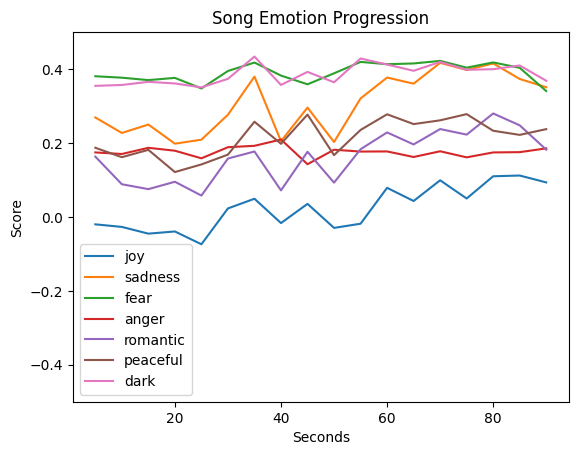

In [6]:
analysis_model.plot(audio_file, classes, batch_duration=5)